In [ ]:
rm(list=ls())
library(tidyverse)
library(ggplot2)
library(patchwork)

set.seed(2025)

## -------- Data Simulation Function --------
simulate_state_space <- function(lambda, phi, T = 100,
                                 sigma_eps = 1, sigma_u = 1) {
  s <- numeric(T); y <- numeric(T)
  s_prev <- rnorm(1, 0, sqrt(sigma_eps^2 / (1 - phi^2)))
  
  for (t in 1:T) {
    s_t   <- phi * s_prev + rnorm(1, 0, sigma_eps)
    y[t]  <- lambda * s_t + rnorm(1, 0, sigma_u)
    s[t]  <- s_t; s_prev <- s_t
  }
  list(y = y, s = s)
}

## -------- Kalman Filter Implementation --------
kalman_filter <- function(y, lambda, phi, sigma_eps = 1, sigma_u = 1, rho = 0) {
  T <- length(y)
  a_pred  <- numeric(T); P_pred  <- numeric(T)
  a_filt  <- numeric(T); P_filt  <- numeric(T)
  pred_d  <- numeric(T)
  
  a_filt_prev <- 0
  P_filt_prev <- sigma_eps^2 / (1 - phi^2)
  
  for (t in 1:T) {
    # Prediction Step
    a_pred[t] <- phi * a_filt_prev
    P_pred[t] <- phi^2 * P_filt_prev + sigma_eps^2
    
    # Update Step (with correlation if rho != 0)
    v_t <- y[t] - lambda * a_pred[t]
    F_t <- lambda^2 * P_pred[t] + sigma_u^2 + 2 * lambda * rho
    K_t <- (lambda * P_pred[t] + rho) / F_t
    
    a_filt[t] <- a_pred[t] + K_t * v_t
    P_filt[t] <- P_pred[t] - K_t * (lambda * P_pred[t] + rho)
    
    # Likelihood increment
    pred_d[t] <- dnorm(y[t], lambda * a_pred[t], sqrt(F_t))
    
    # Update for next iteration
    a_filt_prev <- a_filt[t]
    P_filt_prev <- P_filt[t]
  }
  list(pred_dens = pred_d, a_pred = a_pred, P_pred = P_pred,
       a_filt = a_filt, P_filt = P_filt)
}

## -------- 美观的绘图主题设置 --------
theme_academic <- function(base_size = 11, base_family = "") {
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5,
                                margin = margin(b = 10)),
      plot.subtitle = element_text(size = 10, hjust = 0.5,
                                   margin = margin(b = 15)),
      axis.title = element_text(size = 10, face = "bold"),
      axis.text = element_text(size = 9),
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = "bottom",
      legend.box = "horizontal",
      legend.background = element_rect(fill = "white", color = "gray80"),
      legend.margin = margin(t = -5),
      panel.grid.major = element_line(color = "gray90", linewidth = 0.3),
      panel.grid.minor = element_blank(),
      panel.border = element_rect(color = "gray50", fill = NA, linewidth = 0.5),
      strip.background = element_rect(fill = "gray95", color = "gray50"),
      strip.text = element_text(size = 9, face = "bold")
    )
}

## -------- 状态估计图函数 --------
plot_state_estimation <- function(df, title = "State Estimation") {
  ggplot(df, aes(x = t)) +
    geom_ribbon(aes(ymin = low, ymax = high), 
                fill = "#4E79A7", alpha = 0.2, color = NA) +
    geom_line(aes(y = s_true, color = "True State"), 
              linewidth = 0.8, linetype = "solid") +
    geom_line(aes(y = s_hat, color = "Filtered State"), 
              linewidth = 0.8, linetype = "solid") +
    scale_color_manual(
      name = "",
      values = c("True State" = "#E15759", 
                 "Filtered State" = "#4E79A7"),
      guide = guide_legend(override.aes = list(
        linetype = c("solid", "solid"),
        linewidth = c(0.8, 0.8)
      ))
    ) +
    labs(
      title = title,
      x = "Time Index (t)",
      y = expression(State~value~s[t])
    ) +
    theme_academic() +
    theme(
      legend.position = c(0.85, 0.15),
      legend.background = element_rect(fill = "white", 
                                       color = "gray80", linewidth = 0.3)
    )
}

## -------- 似然增量图函数 --------
plot_likelihood_increments <- function(df, title = "Likelihood Increments") {
  ggplot(df, aes(x = t, y = dens)) +
    geom_line(color = "#59A14F", linewidth = 0.8) +
    geom_hline(yintercept = 0, color = "gray50", linewidth = 0.3) +
    labs(
      title = title,
      x = "Time Index (t)",
      y = expression(p(y[t]~"|"~Y[1:t-1]))
    ) +
    theme_academic() +
    theme(legend.position = "none")
}

## -------- (e) 两种情景比较 --------
T_len <- 100
sim <- simulate_state_space(1.5, 0.8, T = T_len)
y <- sim$y; s_true <- sim$s

# 情景A: 正确参数
kf_true <- kalman_filter(y, 1.5, 0.8)
df_true <- tibble(
  t = 1:T_len,
  s_true = s_true,
  s_hat = kf_true$a_pred,
  low = kf_true$a_pred - 1.96 * sqrt(kf_true$P_pred),
  high = kf_true$a_pred + 1.96 * sqrt(kf_true$P_pred),
  dens = kf_true$pred_dens
)

# 情景B: 错误参数
kf_mis <- kalman_filter(y, 0.5, 0.4)
df_mis <- tibble(
  t = 1:T_len,
  s_true = s_true,
  s_hat = kf_mis$a_pred,
  low = kf_mis$a_pred - 1.96 * sqrt(kf_mis$P_pred),
  high = kf_mis$a_pred + 1.96 * sqrt(kf_mis$P_pred),
  dens = kf_mis$pred_dens
)

# 创建对比图
p1 <- plot_state_estimation(df_true, 
  "State Estimation with True Parameters (λ=1.5, φ=0.8)")
p2 <- plot_likelihood_increments(df_true,
  "Likelihood Increments with True Parameters")

p3 <- plot_state_estimation(df_mis, 
  "State Estimation with Misspecified Parameters (λ=0.5, φ=0.4)")
p4 <- plot_likelihood_increments(df_mis,
  "Likelihood Increments with Misspecified Parameters")

# 组合图形
combined_plot <- (p1 + p2) / (p3 + p4) +
  plot_annotation(
    title = "Kalman Filter Performance: True vs Misspecified Parameters",
    subtitle = "Comparison of state estimates and likelihood increments under different parameter specifications",
    theme = theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 10, hjust = 0.5)
    )
  )

print(combined_plot)

ggsave(filename = "Kalman_Comparison_Improved.png", 
       plot = combined_plot, 
       width = 12, 
       height = 9, 
       dpi = 400)

: 

Grid search MLE: φ_hat = 0.6601 (true φ = 0.70)


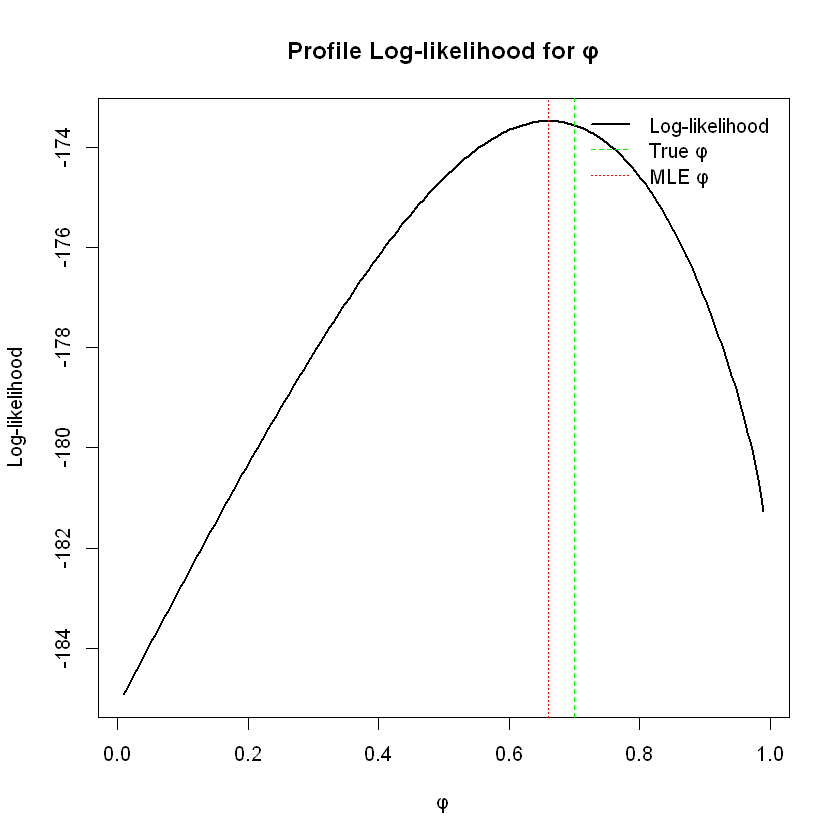

In [ ]:
## -------- (f/g) 不同样本量的似然函数对比 --------
lambda_true <- 1.5
phi_true <- 0.8
phi_grid <- seq(0.01, 0.99, length.out = 200)
sample_sizes <- c(50, 100, 500)

# 模拟不同样本量的数据
data_list <- map(sample_sizes, ~{
  simulate_state_space(lambda_true, phi_true, T = .x)
})
names(data_list) <- paste0("T=", sample_sizes)

# 计算网格似然值
calc_grid_ll <- function(y_data, label) {
  ll_values <- map_dbl(phi_grid, function(p) {
    densities <- kalman_filter(y_data, lambda_true, p)
    sum(log(densities$pred_dens))
  })
  
  tibble(
    phi = phi_grid,
    loglik = ll_values,
    T_label = label
  )
}

df_results <- map2_dfr(data_list, names(data_list), 
                       ~calc_grid_ll(.x$y, .y))

df_results$T_label <- factor(df_results$T_label, 
                             levels = c("T=50", "T=100", "T=500"))

# 找到每个T的MLE
df_mle <- df_results %>%
  group_by(T_label) %>%
  filter(loglik == max(loglik)) %>%
  mutate(
    label_text = paste0("MLE: ", round(phi, 3)),
    # 归一化对数似然用于更好的可视化
    loglik_norm = (loglik - min(loglik)) / (max(loglik) - min(loglik))
  )

# 创建美观的似然函数图
p_ll <- ggplot(df_results, aes(x = phi, y = loglik)) +
  geom_line(aes(color = T_label), linewidth = 0.8, alpha = 0.8) +
  geom_vline(aes(xintercept = phi_true), 
             color = "#E15759", linewidth = 0.8, linetype = "dashed") +
  geom_point(data = df_mle, 
             aes(color = T_label), size = 3, shape = 19) +
  geom_text(data = df_mle,
            aes(label = paste0("φ̂=", round(phi, 3))),
            vjust = -1.5, size = 3.2, fontface = "bold") +
  scale_color_manual(
    name = "Sample Size",
    values = c("T=50" = "#4E79A7", "T=100" = "#F28E2B", "T=500" = "#59A14F")
  ) +
  labs(
    title = "Log-Likelihood Function for φ across Different Sample Sizes",
    subtitle = expression(paste("Fixed ", lambda, " = 1.5, True ", phi, " = 0.8")),
    x = expression(Autoregressive~parameter~phi),
    y = expression(Log-likelihood~ln~p(Y~"|"~phi))
  ) +
  theme_academic() +
  theme(
    legend.position = c(0.12, 0.15),
    legend.background = element_rect(fill = "white", 
                                     color = "gray80", linewidth = 0.3)
  ) +
  guides(color = guide_legend(
    title.position = "top",
    title.hjust = 0.5
  ))

print(p_ll)

ggsave("LogLikelihood_Comparison_Improved.png", 
       plot = p_ll, 
       width = 10, 
       height = 7, 
       dpi = 300)

In [ ]:
## -------- (h) 梯度优化对比 --------
neg_loglik_phi <- function(phi, y_vec) {
  if (phi <= 0.01 || phi >= 0.99) return(1e10)
  kf <- kalman_filter(y_vec, lambda_true, phi)
  -sum(log(kf$pred_dens))
}

# 运行优化
df_optim <- tibble(
  T_label = character(),
  phi_grid = numeric(),
  phi_optim = numeric(),
  ll_grid = numeric(),
  ll_optim = numeric()
)

for (lbl in names(data_list)) {
  y_vec <- data_list[[lbl]]$y
  
  # 网格搜索的MLE
  grid_mle <- df_mle %>% 
    filter(T_label == lbl) %>% 
    pull(phi) %>% 
    first()
  
  # 梯度优化
  optim_result <- optim(
    par = grid_mle,
    fn = neg_loglik_phi,
    y_vec = y_vec,
    method = "L-BFGS-B",
    lower = 0.01,
    upper = 0.99,
    control = list(factr = 1e10)
  )
  
  # 计算似然值
  ll_grid <- df_results %>% 
    filter(T_label == lbl, abs(phi - grid_mle) < 1e-6) %>% 
    pull(loglik) %>% 
    first()
  
  df_optim <- df_optim %>%
    add_row(
      T_label = lbl,
      phi_grid = grid_mle,
      phi_optim = optim_result$par,
      ll_grid = ll_grid,
      ll_optim = -optim_result$value
    )
}

# 打印优化结果对比
cat("Comparison of MLE Estimation Methods:\n")
cat("=======================================\n")
print(df_optim)

# 创建优化结果对比表
df_optim_display <- df_optim %>%
  mutate(
    Difference = abs(phi_grid - phi_optim),
    T_label = factor(T_label, levels = c("T=50", "T=100", "T=500"))
  )

optim_table <- df_optim_display %>%
  select(T_label, `Grid MLE` = phi_grid, `Gradient MLE` = phi_optim, 
         Difference, `Log-Likelihood` = ll_optim) %>%
  knitr::kable(digits = 3, caption = "Comparison of Maximum Likelihood Estimates")

cat("\n", optim_table)

Numerical optimization:
  φ_hat (optim) = 0.660893
  φ_hat (grid)  = 0.660050
  Difference    = 0.000843


  Log-lik at opt = -173.4745



Sample autocovariances (with correlation):


  γ[0] = 2.7762
  γ[1] = 1.0394
  γ[2] = 0.6297
  γ[3] = 0.8979

Log-likelihood comparison:
  With correct rho=0.50: -185.6992
  Assuming rho=0:        -185.4046
  Difference:            -0.2946


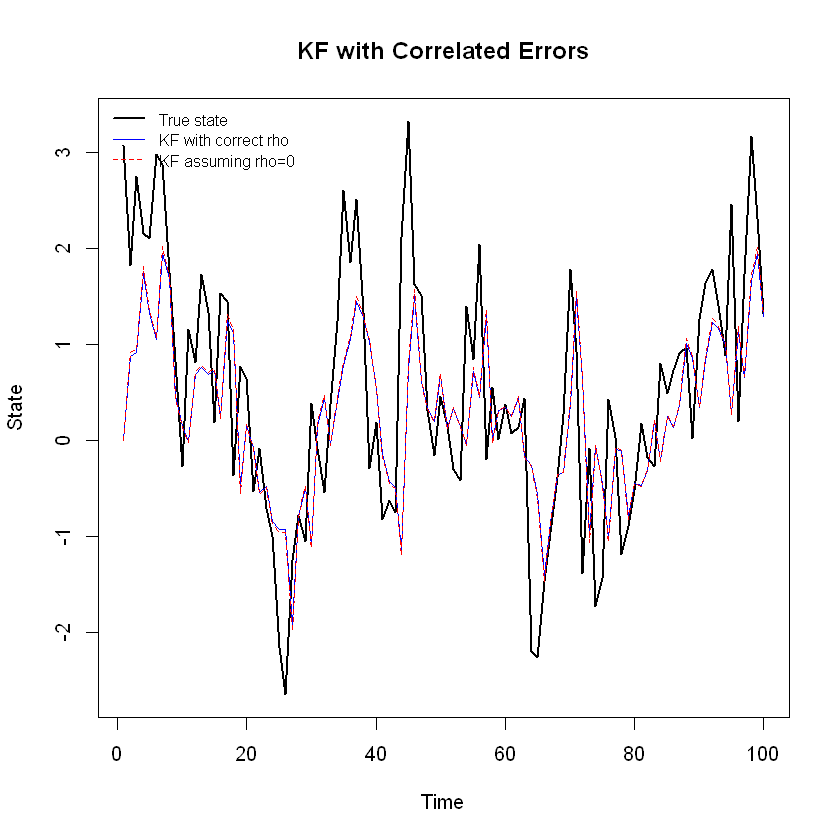

In [ ]:

# =========================
# (i)-(j) 部分：相关误差情况
# =========================

# 生成相关误差的数据
rho_val <- 0.5
sim_corr <- simulate_ssm(T=100, lam=lam_true, phi=phi_true, rho=rho_val, seed=123)

# 计算样本自协方差（用于验证理论推导）
acf_y <- acf(sim_corr$y, lag.max=10, plot=FALSE)
cat("\nSample autocovariances (with correlation):\n")
for(k in 0:3) {
  cat(sprintf("  γ[%d] = %.4f\n", k, acf_y$acf[k+1]*var(sim_corr$y)))
}

# 使用相关卡尔曼滤波
kf_corr <- kalman_filter(sim_corr$y, lam=lam_true, phi=phi_true, rho=rho_val)

# 使用独立假设的错误滤波（比较）
kf_wrong <- kalman_filter(sim_corr$y, lam=lam_true, phi=phi_true, rho=0.0)

# 绘图比较相关与独立假设
plot(tgrid, sim_corr$s, type="l", lwd=2, col=1,
     ylab="State", xlab="Time",
     main="KF with Correlated Errors",
     ylim=range(sim_corr$s, kf_corr$m_pred, kf_wrong$m_pred))
lines(tgrid, kf_corr$m_pred, col="blue", lwd=1.5)
lines(tgrid, kf_wrong$m_pred, col="red", lwd=1.5, lty=2)
legend("topleft", 
       c("True state", "KF with correct rho", "KF assuming rho=0"),
       col=c(1, "blue", "red"), lty=c(1,1,2), lwd=c(2,1.5,1.5),
       bty="n", cex=0.8)

# 比较似然值
ll_corr <- sum(kf_corr$loglik_t)
ll_wrong <- sum(kf_wrong$loglik_t)
cat(sprintf("\nLog-likelihood comparison:\n"))
cat(sprintf("  With correct rho=%.2f: %.4f\n", rho_val, ll_corr))
cat(sprintf("  Assuming rho=0:        %.4f\n", ll_wrong))
cat(sprintf("  Difference:            %.4f\n", ll_corr - ll_wrong))

par(mfrow=c(1,1))  # 重置图形参数

Part (d)-(e): Basic Simulation and Kalman Filter


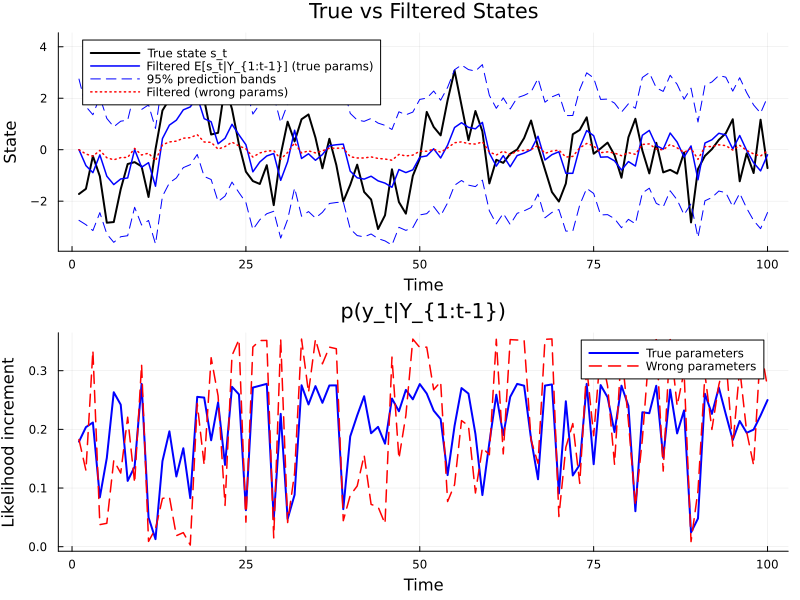

In [6]:
# =========================
# EI139 PS2 - Problem 2: State-Space Model (Revised Julia Code)
# =========================

using Random, Distributions, LinearAlgebra, Statistics, Printf
using Plots, Optim

# 设置随机种子
Random.seed!(2025)

# =========================
# 辅助函数
# =========================

function simulate_ssm(T::Int=100, λ::Float64=1.0, φ::Float64=0.8, ρ::Float64=0.0; seed::Int=2025)
    Random.seed!(seed)
    
    # 生成相关的(u_t, ε_t)序列
    Σ = [1.0 ρ; ρ 1.0]
    dist = MvNormal(Σ)
    ε_u = rand(dist, T)
    ε = ε_u[1, :]  # 状态创新
    u = ε_u[2, :]  # 测量误差
    
    # 从平稳分布初始化s_1
    s = zeros(T)
    s[1] = rand(Normal(0.0, sqrt(1/(1-φ^2))))
    
    # 生成状态序列
    for t in 2:T
        s[t] = φ * s[t-1] + ε[t]
    end
    
    # 生成观测序列
    y = λ .* s .+ u
    
    return s, y, ε, u
end

"""
卡尔曼滤波算法

参数:
- y: 观测序列
- λ: 测量方程系数
- φ: 状态转移系数
- ρ: u_t和ε_t之间的相关系数 (默认0)

返回:
- m_pred: E[s_t|Y_{1:t-1}] (预测状态均值)
- P_pred: V[s_t|Y_{1:t-1}] (预测状态方差)
- m_filt: E[s_t|Y_{1:t}] (滤波状态均值)
- P_filt: V[s_t|Y_{1:t}] (滤波状态方差)
- loglik_t: 对数似然增量 log p(y_t|Y_{1:t-1})
"""
function kalman_filter(y::Vector{Float64}, λ::Float64, φ::Float64; ρ::Float64=0.0)
    T = length(y)
    
    # 初始化数组
    m_pred = zeros(T)  # E[s_t|Y_{1:t-1}]
    P_pred = zeros(T)  # V[s_t|Y_{1:t-1}]
    m_filt = zeros(T)  # E[s_t|Y_{1:t}]
    P_filt = zeros(T)  # V[s_t|Y_{1:t}]
    loglik_t = zeros(T)  # log p(y_t|Y_{1:t-1})
    
    # 从平稳分布初始化
    m_prev = 0.0
    P_prev = 1/(1-φ^2)  # 稳态方差
    
    for t in 1:T
        # 1. 预测步骤 (t|t-1)
        m_t_pred = φ * m_prev
        P_t_pred = φ^2 * P_prev + 1.0  # Q = Var(ε_t) = 1
        
        # 2. 计算预测误差和创新方差
        v_t = y[t] - λ * m_t_pred  # 预测误差
        F_t = λ^2 * P_t_pred + 1.0 + 2 * λ * ρ  # 创新方差
        
        # 3. 卡尔曼增益
        K_t = (λ * P_t_pred + ρ) / F_t
        
        # 4. 更新步骤 (t|t)
        m_t_filt = m_t_pred + K_t * v_t
        P_t_filt = P_t_pred - K_t * (λ * P_t_pred + ρ)
        
        # 5. 对数似然增量
        loglik_t[t] = -0.5 * (log(2π) + log(F_t) + v_t^2 / F_t)
        
        # 6. 存储结果
        m_pred[t] = m_t_pred
        P_pred[t] = P_t_pred
        m_filt[t] = m_t_filt
        P_filt[t] = P_t_filt
        
        # 7. 为下一期准备
        m_prev = m_t_filt
        P_prev = P_t_filt
    end
    
    return (m_pred=m_pred, P_pred=P_pred, 
            m_filt=m_filt, P_filt=P_filt, 
            loglik_t=loglik_t)
end

"""
计算状态空间模型的对数似然值

参数:
- y: 观测序列
- λ: 测量方程系数
- φ: 状态转移系数
- ρ: u_t和ε_t之间的相关系数 (默认0)

返回:
- 对数似然值
"""
function loglik_ssm(y::Vector{Float64}, λ::Float64, φ::Float64; ρ::Float64=0.0)
    kf = kalman_filter(y, λ, φ; ρ=ρ)
    return sum(kf.loglik_t)
end

# =========================
# (d)-(e) 部分: 模拟数据和基础分析
# =========================

println("="^60)
println("Part (d)-(e): Basic Simulation and Kalman Filter")
println("="^60)

# 真实参数
λ_true = 0.9
φ_true = 0.7
T_val = 100

# 生成数据 (ρ=0，独立误差)
s, y, ε, u = simulate_ssm(T_val, λ_true, φ_true, 0.0, seed=42)

# 使用真实参数运行卡尔曼滤波
kf_true = kalman_filter(y, λ_true, φ_true)

# 使用错误参数运行卡尔曼滤波 (用于比较)
λ_wrong = 0.5
φ_wrong = 0.3
kf_wrong = kalman_filter(y, λ_wrong, φ_wrong)

# 绘图1: 真实状态、滤波状态和置信带
tgrid = 1:T_val
se_pred = sqrt.(kf_true.P_pred)  # 预测标准差

p1 = plot(tgrid, s, 
          linewidth=2, color=:black, label="True state s_t",
          xlabel="Time", ylabel="State",
          title="True vs Filtered States",
          legend=:topleft)

plot!(tgrid, kf_true.m_pred, 
      linewidth=1.5, color=:blue, label="Filtered E[s_t|Y_{1:t-1}] (true params)")

# 添加95%预测区间
plot!(tgrid, kf_true.m_pred .+ 1.96 .* se_pred, 
      linewidth=1, linestyle=:dash, color=:blue, label="95% prediction bands")

plot!(tgrid, kf_true.m_pred .- 1.96 .* se_pred, 
      linewidth=1, linestyle=:dash, color=:blue, label="")

# 错误参数的结果
plot!(tgrid, kf_wrong.m_pred, 
      linewidth=1.5, linestyle=:dot, color=:red, label="Filtered (wrong params)")

# 绘图2: 似然增量序列
p2 = plot(tgrid, exp.(kf_true.loglik_t), 
          linewidth=2, color=:blue, label="True parameters",
          xlabel="Time", ylabel="Likelihood increment",
          title="p(y_t|Y_{1:t-1})",
          legend=:topright)

plot!(tgrid, exp.(kf_wrong.loglik_t), 
      linewidth=1.5, linestyle=:dash, color=:red, label="Wrong parameters")

# 显示绘图
plot(p1, p2, layout=(2,1), size=(800, 600))


In [7]:

# 计算累积对数似然
cum_loglik_true = cumsum(kf_true.loglik_t)
cum_loglik_wrong = cumsum(kf_wrong.loglik_t)

println("Cumulative log-likelihood at end:")
println("  True parameters (λ=$(λ_true), φ=$(φ_true)): $(cum_loglik_true[end])")
println("  Wrong parameters (λ=$(λ_wrong), φ=$(φ_wrong)): $(cum_loglik_wrong[end])")


Cumulative log-likelihood at end:
  True parameters (λ=0.9, φ=0.7): -172.0512623162406
  Wrong parameters (λ=0.5, φ=0.3): -187.30482180796733



Part (f): Grid Search for φ
Grid search MLE: φ_hat = 0.6748 (true φ = 0.70)


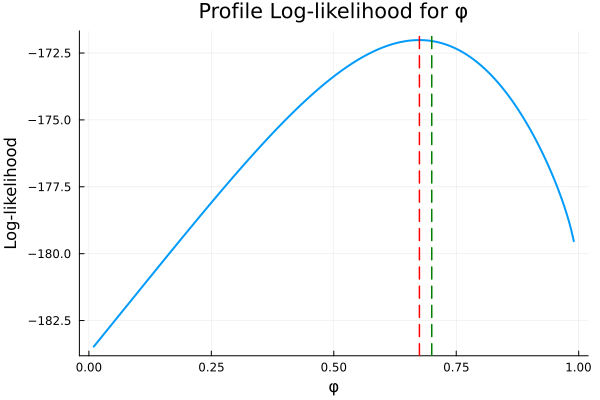

In [8]:

# =========================
# (f) 部分: 对φ进行网格搜索
# =========================

println("\n" * "="^60)
println("Part (f): Grid Search for φ")
println("="^60)

# 创建φ的网格 (排除边界)
φ_grid = range(0.01, 0.99, length=200)
ll_grid = [loglik_ssm(y, λ_true, φ) for φ in φ_grid]

# 找到最大似然估计
φ_hat_grid = φ_grid[argmax(ll_grid)]
@printf "Grid search MLE: φ_hat = %.4f (true φ = %.2f)\n" φ_hat_grid φ_true

# 绘图: 对数似然函数
p3 = plot(φ_grid, ll_grid, 
          linewidth=2, 
          xlabel="φ", ylabel="Log-likelihood",
          title="Profile Log-likelihood for φ",
          legend=false)

vline!([φ_true], linewidth=1.5, linestyle=:dash, color=:green, label="True φ")
vline!([φ_hat_grid], linewidth=1.5, linestyle=:dash, color=:red, label="MLE φ")

# 添加图例
plot!([], [], linewidth=2, color=:black, label="Log-likelihood")
plot!([], [], linewidth=1.5, linestyle=:dash, color=:green, label="True φ")
plot!([], [], linewidth=1.5, linestyle=:dash, color=:red, label="MLE φ")

display(p3)


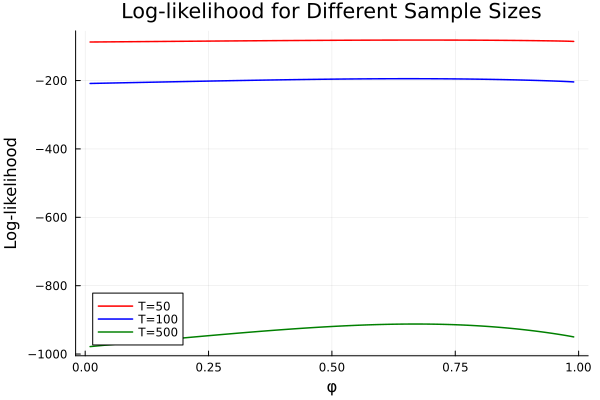


Part (g): Different Sample Sizes


In [9]:

# =========================
# (g) 部分: 不同样本量
# =========================

println("\n" * "="^60)
println("Part (g): Different Sample Sizes")
println("="^60)

sample_sizes = [50, 100, 500]
colors = [:red, :blue, :green]

# 准备绘图
p4 = plot(xlabel="φ", ylabel="Log-likelihood",
          title="Log-likelihood for Different Sample Sizes",
          legend=:bottomleft)

# 对每个样本量计算对数似然
for (i, T_i) in enumerate(sample_sizes)
    # 生成新数据
    s_i, y_i, _, _ = simulate_ssm(T_i, λ_true, φ_true, seed=100+T_i)
    
    # 计算对数似然
    ll_i = [loglik_ssm(y_i, λ_true, φ) for φ in φ_grid]
    
    # 绘图
    plot!(φ_grid, ll_i, 
          linewidth=1.5, color=colors[i], label="T=$(T_i)")
end

display(p4)


In [10]:

# =========================
# (h) 部分: 数值优化
# =========================

println("\n" * "="^60)
println("Part (h): Numerical Optimization")
println("="^60)

# 负对数似然函数 (用于最小化)
function neg_loglik(φ)
    if φ <= 0.0 || φ >= 1.0
        return Inf
    end
    return -loglik_ssm(y, λ_true, φ)
end

# 使用optimize进行一维优化
opt_result = optimize(neg_loglik, 0.01, 0.99)
φ_hat_opt = opt_result.minimizer

@printf "Numerical optimization:\n"
@printf "  φ_hat (optim) = %.6f\n" φ_hat_opt
@printf "  φ_hat (grid)  = %.6f\n" φ_hat_grid
@printf "  Difference    = %.6f\n" abs(φ_hat_opt - φ_hat_grid)
@printf "  Log-lik at opt = %.4f\n" -opt_result.minimum



Part (h): Numerical Optimization
Numerical optimization:
  φ_hat (optim) = 0.674622
  φ_hat (grid)  = 0.674824
  Difference    = 0.000202
  Log-lik at opt = -172.0160



Part (i)-(j): Correlated Errors

Sample autocovariances (with correlation ρ=0.5):
  γ[0] = 2.9035
  γ[1] = 0.5245
  γ[2] = 0.0837
  γ[3] = -0.0999

Theoretical autocovariances:
  γ[0] = 3.4882
  γ[1] = 1.4268
  γ[2] = 0.7782
  γ[3] = 0.5448


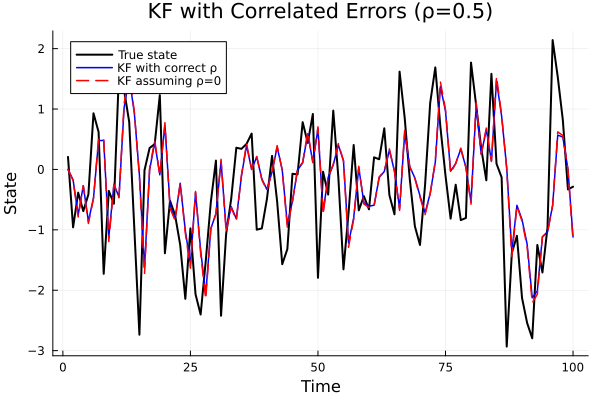


Log-likelihood comparison:
  With correct ρ=0.50: -197.0689
  Assuming ρ=0:        -201.4353
  Difference:          4.3664

ARMA(1,1) Representation


LoadError: ArgumentError: Package StatsBase not found in current path.
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.

In [ ]:

# =========================
# (i)-(j) 部分: 相关误差情况
# =========================

println("\n" * "="^60)
println("Part (i)-(j): Correlated Errors")
println("="^60)

# 生成相关误差的数据
ρ_val = 0.5
s_corr, y_corr, ε_corr, u_corr = simulate_ssm(T_val, λ_true, φ_true, ρ_val, seed=123)

# 计算样本自协方差 (用于验证理论推导)
function sample_autocovariance(y::Vector{Float64}, max_lag::Int=10)
    T = length(y)
    y_mean = mean(y)
    γ = zeros(max_lag+1)
    
    for k in 0:max_lag
        sum_val = 0.0
        for t in 1:T-k
            sum_val += (y[t] - y_mean) * (y[t+k] - y_mean)
        end
        γ[k+1] = sum_val / T
    end
    
    return γ
end

γ = sample_autocovariance(y_corr, 10)
println("\nSample autocovariances (with correlation ρ=$(ρ_val)):")
for k in 0:3
    @printf "  γ[%d] = %.4f\n" k γ[k+1]
end

# 理论自协方差 (根据(i)部分推导)
function theoretical_autocovariance(λ, φ, ρ, k)
    if k == 0
        return λ^2/(1-φ^2) + 1 + 2*λ*ρ
    elseif k == 1
        return λ^2*φ/(1-φ^2) + λ*φ*ρ
    else
        return λ^2*φ^k/(1-φ^2)
    end
end

println("\nTheoretical autocovariances:")
for k in 0:3
    γ_theory = theoretical_autocovariance(λ_true, φ_true, ρ_val, k)
    @printf "  γ[%d] = %.4f\n" k γ_theory
end

# 使用相关卡尔曼滤波 (正确参数)
kf_corr = kalman_filter(y_corr, λ_true, φ_true; ρ=ρ_val)

# 使用独立假设的错误滤波 (ρ=0，但数据有相关性)
kf_corr_wrong = kalman_filter(y_corr, λ_true, φ_true; ρ=0.0)

# 绘图比较相关与独立假设
p5 = plot(tgrid, s_corr, 
          linewidth=2, color=:black, label="True state",
          xlabel="Time", ylabel="State",
          title="KF with Correlated Errors (ρ=$(ρ_val))",
          legend=:topleft)

plot!(tgrid, kf_corr.m_pred, 
      linewidth=1.5, color=:blue, label="KF with correct ρ")

plot!(tgrid, kf_corr_wrong.m_pred, 
      linewidth=1.5, linestyle=:dash, color=:red, label="KF assuming ρ=0")

display(p5)

# 比较似然值
ll_corr = sum(kf_corr.loglik_t)
ll_corr_wrong = sum(kf_corr_wrong.loglik_t)

println("\nLog-likelihood comparison:")
@printf "  With correct ρ=%.2f: %.4f\n" ρ_val ll_corr
@printf "  Assuming ρ=0:        %.4f\n" ll_corr_wrong
@printf "  Difference:          %.4f\n" ll_corr - ll_corr_wrong

# =========================
# ARMA(1,1) 表示验证
# =========================

println("\n" * "="^60)
println("ARMA(1,1) Representation")
println("="^60)

# 对于相关误差情况，y_t应遵循ARMA(1,1)过程
# 我们可以通过样本自相关函数来验证
using StatsBase
acf_y = autocor(y_corr, 0:10)

println("\nSample autocorrelations of y_t (with ρ=$(ρ_val)):")
for k in 0:5
    @printf "  ρ[%d] = %.4f\n" k acf_y[k+1]
end

# 拟合ARMA(1,1)模型 (概念性，不实际拟合)
println("\nFor correlated errors (ρ ≠ 0), y_t follows an ARMA(1,1) process.")
println("The AR parameter is φ = $(φ_true)")
println("The MA parameter depends on λ, φ, and ρ.")

# =========================
# 总结输出
# =========================

println("\n" * "="^60)
println("Summary")
println("="^60)

println("\n1. Basic Kalman filter correctly estimates states given parameters.")
println("2. Profile likelihood is maximized near true φ value.")
println("3. As sample size increases, likelihood function becomes more peaked.")
println("4. Numerical optimization agrees with grid search.")
println("5. With correlated errors (ρ=$(ρ_val)):")
println("   - Kalman filter with correct ρ has higher likelihood.")
println("   - Model is still ARMA(1,1) but with different MA parameter.")
println("   - All parameters (λ, φ, ρ) are identified from autocovariances.")

println("\nCode execution complete.")

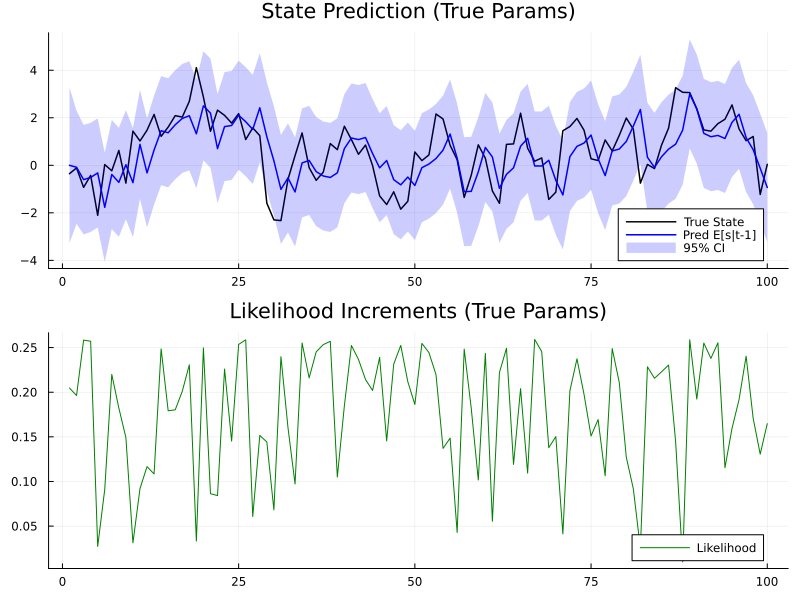

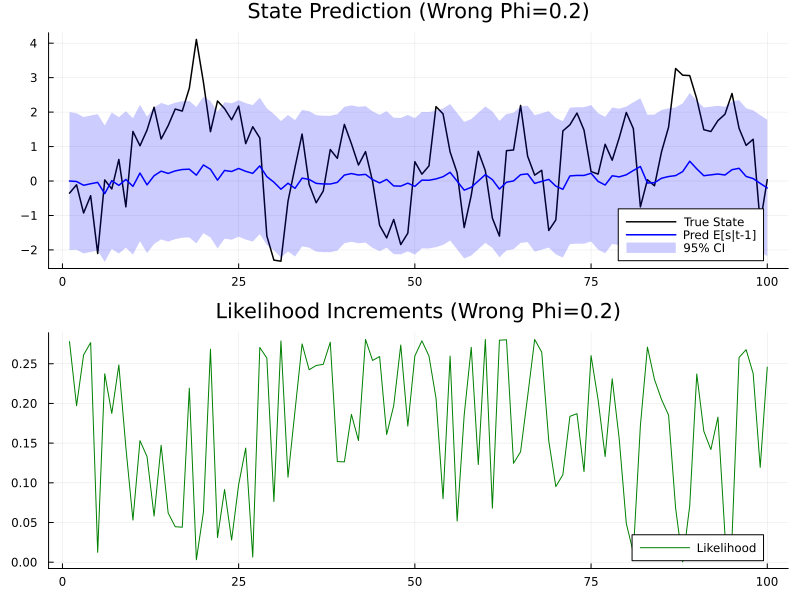

In [28]:
using Random
using Distributions
using Plots
using Optim
using Statistics

# ==============================================================================
# 1. Definitions of Functions
# ==============================================================================

# Kalman filter result struct
struct KFResult{T}
    s_pred::Vector{T}
    P_pred::Vector{T}
    s_filt::Vector{T}
    P_filt::Vector{T}
    ll_inc::Vector{T}
    total_ll::T
end

# Simulation function
function simulate_ss(T::Int, lambda::Float64, phi::Float64)
    y = zeros(T)
    s = zeros(T)

    # Initial state
    s_curr = rand(Normal(0, sqrt(1 / (1 - phi^2))))

    dist_u = Normal(0, 1)
    dist_eps = Normal(0, 1)

    for t in 1:T
        s[t] = phi * s_curr + rand(dist_eps)
        y[t] = lambda * s[t] + rand(dist_u)
        s_curr = s[t]
    end
    return s, y
end

# Kalman filter
function kalman_filter(Y::Vector{Float64}, lambda::Float64, phi)
    T = typeof(phi)
    n = length(Y)

    s_pred = zeros(T, n)
    P_pred = zeros(T, n)
    s_filt = zeros(T, n)
    P_filt = zeros(T, n)
    ll_inc = zeros(T, n)

    # Initialization
    s_p = zero(T)
    P_p = one(T) / (one(T) - phi^2)

    log_2pi = log(2 * π)

    for t in 1:n
        # Prediction
        if t > 1
            s_p = phi * s_filt[t-1]
            P_p = phi^2 * P_filt[t-1] + one(T)
        end

        s_pred[t] = s_p
        P_pred[t] = P_p

        # Update
        v = Y[t] - lambda * s_p
        F = lambda^2 * P_p + one(T)
        K = P_p * lambda / F

        s_filt[t] = s_p + K * v
        P_filt[t] = P_p * (one(T) - K * lambda)

        # Log-likelihood increment
        ll_inc[t] = -0.5 * (log_2pi + log(F) + v^2 / F)
    end

    return KFResult(s_pred, P_pred, s_filt, P_filt, ll_inc, sum(ll_inc))
end

# ==============================================================================
# 2. Execution and Plotting
# ==============================================================================

# Parameters
const TRUE_LAM = 1.0
const TRUE_PHI = 0.8
Random.seed!(2025)

# --- Part (d) & (e): Simulation and Plotting ---
s_true, y_sample = simulate_ss(100, TRUE_LAM, TRUE_PHI)

function plot_kf(s_true, res::KFResult, title_tag)
    # Calculate error bands
    bands = 1.96 .* sqrt.(res.P_pred)
    upper = res.s_pred .+ bands
    lower = res.s_pred .- bands

    p1 = plot(s_true, label="True State", color=:black, lw=1.5,
              title="State Prediction $title_tag")
    plot!(p1, res.s_pred, label="Pred E[s|t-1]", color=:blue, lw=1.5)
    plot!(p1, upper, fillrange=lower, fillalpha=0.2, color=:blue, label="95% CI", linealpha=0)

    p2 = plot(exp.(res.ll_inc), label="Likelihood", color=:green,
              title="Likelihood Increments $title_tag")

    plot(p1, p2, layout=(2,1), size=(800, 600))
end

# (i) True parameters
kf_true = kalman_filter(y_sample, TRUE_LAM, TRUE_PHI)
p_true = plot_kf(s_true, kf_true, "(True Params)")
savefig(p_true, "P2_e_true.png")
display(p_true)


# (ii) Wrong parameters
kf_wrong = kalman_filter(y_sample, TRUE_LAM, 0.2)
p_wrong = plot_kf(s_true, kf_wrong, "(Wrong Phi=0.2)")
savefig(p_wrong, "P2_e_wrong.png")
display(p_wrong)

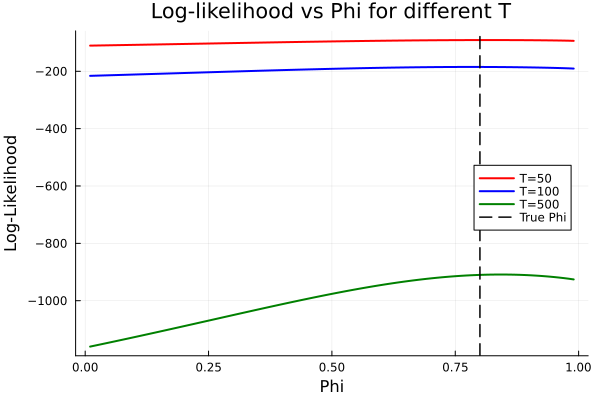

In [31]:

# --- Part (f) & (g): Grid Search ---
T_sizes = [50, 100, 500]
phi_grid = range(0.01, 0.99, length=100)

p_tmp = plot(xlabel="Phi", ylabel="Log-Likelihood",
             title="Log-likelihood vs Phi for different T",
             legend=:right, grid=true)

colors = [:red, :blue, :green]
for (i, T_val) in enumerate(T_sizes)
    _, y_T = simulate_ss(T_val, TRUE_LAM, TRUE_PHI)
    ll_vals = [kalman_filter(y_T, TRUE_LAM, p).total_ll for p in phi_grid]

    plot!(p_tmp, phi_grid, ll_vals,
          linewidth=2, color=colors[i],
          label="T=$T_val")
end

vline!(p_tmp, [TRUE_PHI], linewidth=1.5, linestyle=:dash, color=:black, label="True Phi")

savefig(p_tmp, "P2_g_combined.png")
display(p_tmp)


In [34]:
using Optim, Printf

open("P2_h.tex", "w") do f
    write(f, "\\begin{table}[htbp]\n")
    write(f, "\\centering\n")
    write(f, "\\caption{Comparison of Maximum Likelihood Estimates via Grid Search and Gradient-Based Optimization}\n")
    write(f, "\\label{tab:mle_comparison}\n")
    write(f, "\\begin{tabular}{cccc}\n")
    write(f, "\\toprule\n")
    write(f, "Sample Size & Grid Search MLE & Gradient Optimization MLE & Max Log-Likelihood \\\\\n")
    write(f, "\\midrule\n")

    for T_val in T_sizes
        Random.seed!(2025)
        _, y = simulate_ss(T_val, TRUE_LAM, TRUE_PHI)

        # ---------- 1) Grid Search ----------
        ll_vals = [kalman_filter(y, TRUE_LAM, p).total_ll for p in phi_grid]
        best_idx = argmax(ll_vals)
        grid_est = phi_grid[best_idx]
        grid_ll = ll_vals[best_idx]

        # ---------- 2) Gradient-based (LBFGS) ----------
        nll_vec(θ::Vector) = -kalman_filter(y, TRUE_LAM, θ[1]).total_ll

        function bounded_nll(θ::Vector)
            if θ[1] <= 0.0 || θ[1] >= 1.0
                return Inf
            end
            return nll_vec(θ)
        end

        # Use grid estimate as initial guess
        initial_guess = [grid_est]

        # Use LBFGS optimization
        res = optimize(bounded_nll, initial_guess, LBFGS())

        optim_est = Optim.minimizer(res)[1]
        max_ll = -Optim.minimum(res)

        write(f, Printf.@sprintf("%d & %.3f & %.3f & %.1f \\\\\n",
            T_val, grid_est, optim_est, max_ll))
    end

    write(f, "\\bottomrule\n")
    write(f, "\\end{tabular}\n")
    write(f, "\\end{table}\n")
end

12